In [1]:
import sys
import os
import logging
from IPython import get_ipython
logger = logging.getLogger(name="Diversity analysis app")

if 'google.colab' in str(get_ipython()):
    print('Setting Google colab, you will need a ngrok account to make the dashboard display over the tunnel. \
    https://ngrok.com/')
    # clone the momics-demos repository to use it to load data
    try:
        os.system('git clone https://github.com/palec87/momics-demos.git')
        logger.info(f"Repository cloned")
    except OSError as e:
        logger.info(f"An error occurred while cloning the repository: {e}")

    sys.path.insert(0,'/content/momics-demos')

    # this step takes time beacause of many dependencies
    os.system('pip install marine-omics')

from momics.utils import (
    memory_load, reconfig_logger,
    init_setup, get_notebook_environment,
)

# Set up logging
reconfig_logger()

# Determine the notebook environment
env = get_notebook_environment()

init_setup()
logger.info(f"Environment: {env}")

INFO | root | Logging.basicConfig completed successfully
INFO | Diversity analysis app | Environment: vscode


In [2]:
import warnings
import holoviews as hv
from skbio.stats.ordination import pcoa

from functools import partial
warnings.filterwarnings('ignore')

import pandas as pd
import panel as pn

from mgo.udal import UDAL

# All low level functions are imported from the momics package
from momics.loader import load_parquets_udal
from momics.metadata import get_metadata_udal, enhance_metadata
import momics.plotting as pl
from momics.panel_utils import diversity_select_widgets

from momics.diversity import (
    beta_diversity_parametrized,
)
from momics.utils import load_and_clean, taxonomy_common_preprocess01

In [3]:
DEBUG = True  # enable stdout logging

# parquet files
if 'google.colab' in str(get_ipython()):
    root_folder = os.path.abspath(os.path.join('/content/momics-demos'))
else:
    root_folder = os.path.abspath(os.path.join('../'))

assets_folder = os.path.join(root_folder, 'assets')


def get_valid_samples():
    df_valid = pd.read_csv(
        os.path.join(root_folder, 'data/shipment_b1b2_181.csv')
    )
    return df_valid

valid_samples = get_valid_samples()

In [4]:
# High level function from the momics.utils module
full_metadata, mgf_parquet_dfs = load_and_clean(valid_samples=valid_samples)

# select categorical columns from metadata
categorical_columns = sorted(full_metadata.select_dtypes(include=['object', "boolean"]).columns)

# select numerical columns from metadata
numerical_columns = sorted(full_metadata.select_dtypes(include=['int64', 'float64']).columns)

if DEBUG:
    logger.info(f"Data table names are:\n{mgf_parquet_dfs.keys()}")
    logger.info(f"Categorical metadata columns are:\n{categorical_columns}")
    logger.info(f"Numerical metadata columns are:\n{numerical_columns}")

INFO | Diversity analysis app | Data table names are:
dict_keys(['go', 'go_slim', 'ips', 'ko', 'pfam', 'lsu', 'ssu'])
INFO | Diversity analysis app | Categorical metadata columns are:
['ammonium method', 'chlorophyll method', 'conductivity method', 'country', 'density method', 'dissolved oxygen method', 'environment (biome)', 'environment (feature)', 'environment (material)', 'environmental package', 'investigation type', 'month name', 'nitrate method', 'nitrite method', 'observatory ID', 'observatory local location', 'observatory location ocean or sea', 'observatory regional location', 'organism count', 'organism count method', 'organization', 'organization country', 'pH method', 'phaeopigments method', 'phosphate method', 'pigments (ug/l)', 'pigments method', 'pressure method', 'project name', 'replicate info', 'replicate number', 'sample collection device or method', 'sea subsurface salinity method', 'sea subsurface temperature method', 'sea surface salinity method', 'sea surface te

In [5]:
(select_table, select_cat_factor, 
 select_table_beta, select_taxon,
 select_beta_factor, beta_norm,
 ) = diversity_select_widgets(categorical_columns, numerical_columns)
select_taxon.value = 'phylum'

In [6]:
tables = {
    "lsu": mgf_parquet_dfs['lsu'].copy(),
    "ssu": mgf_parquet_dfs['ssu'].copy(),
}

TAXONOMY = pd.DataFrame()
TAXONOMY_RANKS = ['superkingdom', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

# redefine select_table_beta
select_table_beta = pn.widgets.Select(
    name='Select table for beta diversity',
    options=list(tables.keys()),
    value='ssu',
)

In [9]:
pn.Column(
    pn.Row(
        select_table_beta,
        select_taxon,
        select_beta_factor,
        
    )
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'dd2a875a-8c0a-4e18-83c7-7e52bea2cb2d': {'version…

In [13]:
beta_pc_plot, explained_var = pl.beta_plot_pc(
    tables_dict=tables,
    metadata=full_metadata,
    table_name=select_table_beta.value,
    factor=select_beta_factor.value,
    taxon=select_taxon.value,
)

# display
beta_pc_plot = beta_pc_plot.opts(
        title=f'Beta diversity PCA plot for {select_table_beta.value} table',
        width=1000,
        height=600,
    )
beta_pc_plot

:Scatter   [PC1]   (PC2,pH,sample)

## Now the permanova

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from momics.taxonomy import (
    pivot_taxonomic_data,
    separate_taxonomy,
)

from momics.diversity import run_permanova
from momics.metadata import filter_metadata_table, filter_data

In [31]:
def pivot(lsu, ssu):

    lsu_standard = pivot_taxonomic_data(lsu)
    ssu_standard = pivot_taxonomic_data(ssu)

    split_taxo_tables_lsu = separate_taxonomy(lsu_standard)
    split_taxo_tables_ssu = separate_taxonomy(ssu_standard)

    global granular_tables
    granular_tables = {
        "LSU": split_taxo_tables_lsu,
        "SSU": split_taxo_tables_ssu
    }

pivot(tables['ssu'], tables['ssu'])

In [117]:
granular_tables['SSU'].keys()

dict_keys(['Prokaryotes All', 'Eukaryota All', 'Bacteria', 'Archaea', 'Bacteria_phylum', 'Bacteria_class', 'Bacteria_order', 'Bacteria_family', 'Bacteria_genus'])

In [16]:
help(run_permanova)

Help on function run_permanova in module momics.diversity:

run_permanova(data: pandas.core.frame.DataFrame, metadata: pandas.core.frame.DataFrame, permanova_factor: str, permanova_group: List[str], permanova_additional_factors: List[str], permutations: int = 999, verbose: bool = False) -> Dict[str, pandas.core.frame.DataFrame]
    Run PERMANOVA on the given data and metadata.
    Args:
        data (pd.DataFrame): DataFrame containing the abundance data.
        metadata (pd.DataFrame): DataFrame containing the metadata.
        permanova_factor (str): The factor to use for PERMANOVA.
        permanova_group (List[str]): List of groups to include in the analysis.
        permanova_additional_factors (List[str]): Additional factors to test.
        permutations (int): Number of permutations for PERMANOVA. Default is 999.
        verbose (bool): If True, print detailed output.
    Returns:
        Dict[str, pd.DataFrame]: Dictionary containing PERMANOVA results for each factor.



In [122]:
perm_group = ['EMOBON_NRMCB_So_16', 'EMOBON_NRMCB_Wa_49','EMOBON_EMT21_Wa_2']
selected_factors = {'season': ['All'], 'country': ['All']}

In [111]:
metadata = full_metadata.loc[full_metadata.index.isin(perm_group)]
metadata[['pH', 'season', 'country']]

,pH,season,country
source material ID,,,
EMOBON_EMT21_Wa_2,8.210,Summer,Spain
EMOBON_NRMCB_Wa_49,8.213,Autumn,Italy
EMOBON_NRMCB_So_16,7.500,Winter,Italy


In [112]:
data = granular_tables['SSU']['Prokaryotes All'][perm_group]
data.head()

source material ID,EMOBON_NRMCB_So_16,EMOBON_NRMCB_Wa_49,EMOBON_EMT21_Wa_2
taxonomic_concat,,,
2;sk__Bacteria;k__;p__;c__;o__;f__;g__;s__,297,582,1925
6;sk__Bacteria;k__;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Azorhizobium;s__,0,0,0
10;sk__Bacteria;k__;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Cellvibrionaceae;g__Cellvibrio;s__,0,0,0
16;sk__Bacteria;k__;p__Proteobacteria;c__Betaproteobacteria;o__Nitrosomonadales;f__Methylophilaceae;g__Methylophilus;s__,0,0,0
18;sk__Bacteria;k__;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfuromonadales;f__Desulfuromonadaceae;g__Pelobacter;s__,0,0,0


In [113]:
def get_filtered_metadata(metadata, selected_factors):
    # Filter the metadata table
    filtered_metadata = filter_metadata_table(metadata, selected_factors)
    return filtered_metadata

def filter_inputs(df, metadata, selected_factors):
    # Retrieve the filtered metadata
    filtered_metadata = get_filtered_metadata(metadata, selected_factors)
    # Filter the data
    filtered_data = filter_data(df, filtered_metadata)
    assert not filtered_data.empty, "Filtered data is empty. Check your selections."
    return filtered_metadata, filtered_data

In [123]:
# metadata, data = filter_inputs(data, metadata, selected_factors)

metadata, data = filter_inputs(granular_tables['SSU']['Prokaryotes All'], full_metadata,selected_factors)
data.head()

source material ID,EMOBON_AAOT_Wa_1,EMOBON_AAOT_Wa_2,EMOBON_AAOT_Wa_22,EMOBON_AAOT_Wa_26,EMOBON_AAOT_Wa_27,EMOBON_AAOT_Wa_41,EMOBON_AAOT_Wa_42,EMOBON_AAOT_Wa_46,EMOBON_AAOT_Wa_47,EMOBON_AAOT_Wa_6,...,EMOBON_VB_Wa_4,EMOBON_VB_Wa_41,EMOBON_VB_Wa_42,EMOBON_VB_Wa_43,EMOBON_VB_Wa_44,EMOBON_VB_Wa_5,EMOBON_VB_Wa_93,EMOBON_VB_Wa_94,EMOBON_VB_Wa_96,EMOBON_VB_Wa_97
taxonomic_concat,,,,,,,,,,,,,,,,,,,,,
2;sk__Bacteria;k__;p__;c__;o__;f__;g__;s__,1256,1783,1920,895,536,848,461,534,304,1172,...,765,769,1106,1449,996,978,456,552,1908,1120
6;sk__Bacteria;k__;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Azorhizobium;s__,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10;sk__Bacteria;k__;p__Proteobacteria;c__Gammaproteobacteria;o__Cellvibrionales;f__Cellvibrionaceae;g__Cellvibrio;s__,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16;sk__Bacteria;k__;p__Proteobacteria;c__Betaproteobacteria;o__Nitrosomonadales;f__Methylophilaceae;g__Methylophilus;s__,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18;sk__Bacteria;k__;p__Proteobacteria;c__Deltaproteobacteria;o__Desulfuromonadales;f__Desulfuromonadaceae;g__Pelobacter;s__,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
permanova_results = run_permanova(
        # granular_tables['SSU']['Prokaryotes All'],
        # full_metadata,
        data,
        metadata=metadata,
        permanova_factor = 'All',
        permanova_group = perm_group,
        permanova_additional_factors = ['season', 'country', 'pH'],
        permutations=999,  # 29 for binder, 999 for local
        verbose=True,
    )

INFO | momics.diversity | Factor: season
INFO | momics.diversity |   F-statistic: 2.5258
INFO | momics.diversity |   p-value: 0.0010

INFO | momics.diversity | Factor: country
INFO | momics.diversity |   F-statistic: 3.8019
INFO | momics.diversity |   p-value: 0.0010

INFO | momics.diversity | Factor: pH
INFO | momics.diversity |   F-statistic: 4.3157
INFO | momics.diversity |   p-value: 0.0010



In [125]:
df_results = pd.DataFrame(permanova_results)
df_results

,season,country,pH
method name,PERMANOVA,PERMANOVA,PERMANOVA
test statistic name,pseudo-F,pseudo-F,pseudo-F
sample size,181,181,68
number of groups,4,9,21
test statistic,2.52583,3.801889,4.315673
p-value,0.001,0.001,0.001
number of permutations,999,999,999


In [126]:
data.shape

(3705, 181)

In [162]:
# iterate over rows and remove one by one for the permanova
taxon, stats = [], []
counter = 0
for idx, row in data.iloc[::10, :].iterrows():
    df_removed = data.drop(index=idx)
    permanova_results = run_permanova(
        # granular_tables['SSU']['Prokaryotes All'],
        # full_metadata,
        df_removed,
        metadata=metadata,
        permanova_factor = 'All',
        permanova_group = perm_group,
        permanova_additional_factors = ['season'],
        permutations=499,  # 29 for binder, 999 for local
        verbose=False,
    )
    taxon.append(row.name)
    stats.append(permanova_results['season']['test statistic'])
    counter += 1
    print(counter, end='\r')

In [157]:
# taxon

In [163]:
np.argmin(stats)

np.int64(348)

In [165]:
taxon[np.argmin(stats)]

'1890424;sk__Bacteria;k__;p__Cyanobacteria;c__;o__Synechococcales;f__;g__;s__'

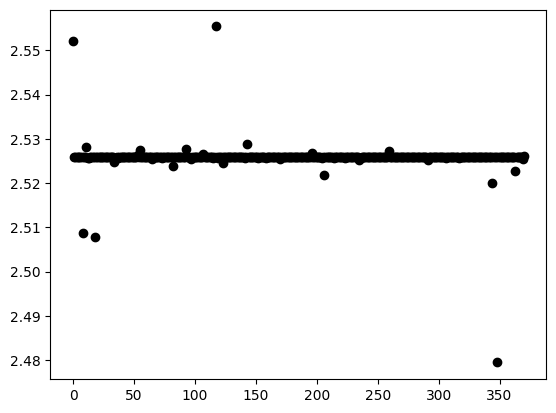

In [164]:
plt.plot(stats, 'ko')